In [10]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
import torch
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

In [11]:
# Use TrOCR model which is designed for OCR tasks
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Combination of Models
Combine license plate detection model with the text recognition model

In [ ]:
# Use license plate detection model
def detect_license_plates(image_path):

    detector = YOLO('../../models/trained/license_plate_detector6/weights/best.pt')
    
    # Run detection with the YOLO model
    results = detector(image_path)
    
    # Process the results to the desired format
    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Round coordinates to integers
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            # Get confidence score
            confidence = float(box.conf[0])
            
            # Add the detection to the list
            detections.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': confidence
            })
    
    return detections

In [ ]:
# Function to read text from a cropped license plate with OCR model
def read_license_plate(plate_image):
    # Convert the image to the correct format for the model
    if isinstance(plate_image, np.ndarray):  # If it's a cv2/numpy image
        plate_image = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
    
    # Use the processor to prepare the input for the model
    pixel_values = processor(images=plate_image, return_tensors="pt").pixel_values
    
    # Generate text from the image
    generated_ids = model.generate(pixel_values)
    license_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return license_text

In [ ]:
# Complete pipeline function
def process_image(image_path):
    # Step 1: Detect license plates
    detections = detect_license_plates(image_path)
    
    # Step 2: Read each detected license plate
    results = []
    
    # Load the original image
    image = cv2.imread(image_path)
    
    for detection in detections:
        # Get the bounding box
        x1, y1, x2, y2 = detection['bbox']
        
        # Crop the license plate from the image
        plate_image = image[y1:y2, x1:x2]
        
        # Read the text from the license plate
        plate_text = read_license_plate(plate_image)
        
        # Save the result
        results.append({
            'bbox': detection['bbox'],
            'confidence': detection['confidence'],
            'text': plate_text
        })
    
    return results

Test directory: ../../datasets/license_plate_dataset/images/test
Found 386 image files in test directory



image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/6eb18d1ad17cd174.jpg: 448x640 1 license_plate, 240.2ms
Speed: 15.2ms preprocess, 240.2ms inference, 22.4ms postprocess per image at shape (1, 3, 448, 640)
image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/6eb18d1ad17cd174.jpg: 448x640 1 license_plate, 240.2ms
Speed: 15.2ms preprocess, 240.2ms inference, 22.4ms postprocess per image at shape (1, 3, 448, 640)


image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/4572990fd64bb6be.jpg: 512x640 2 license_plates, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)
image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/4572990fd64bb6be.jpg: 512x640 2 license_plates, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/12

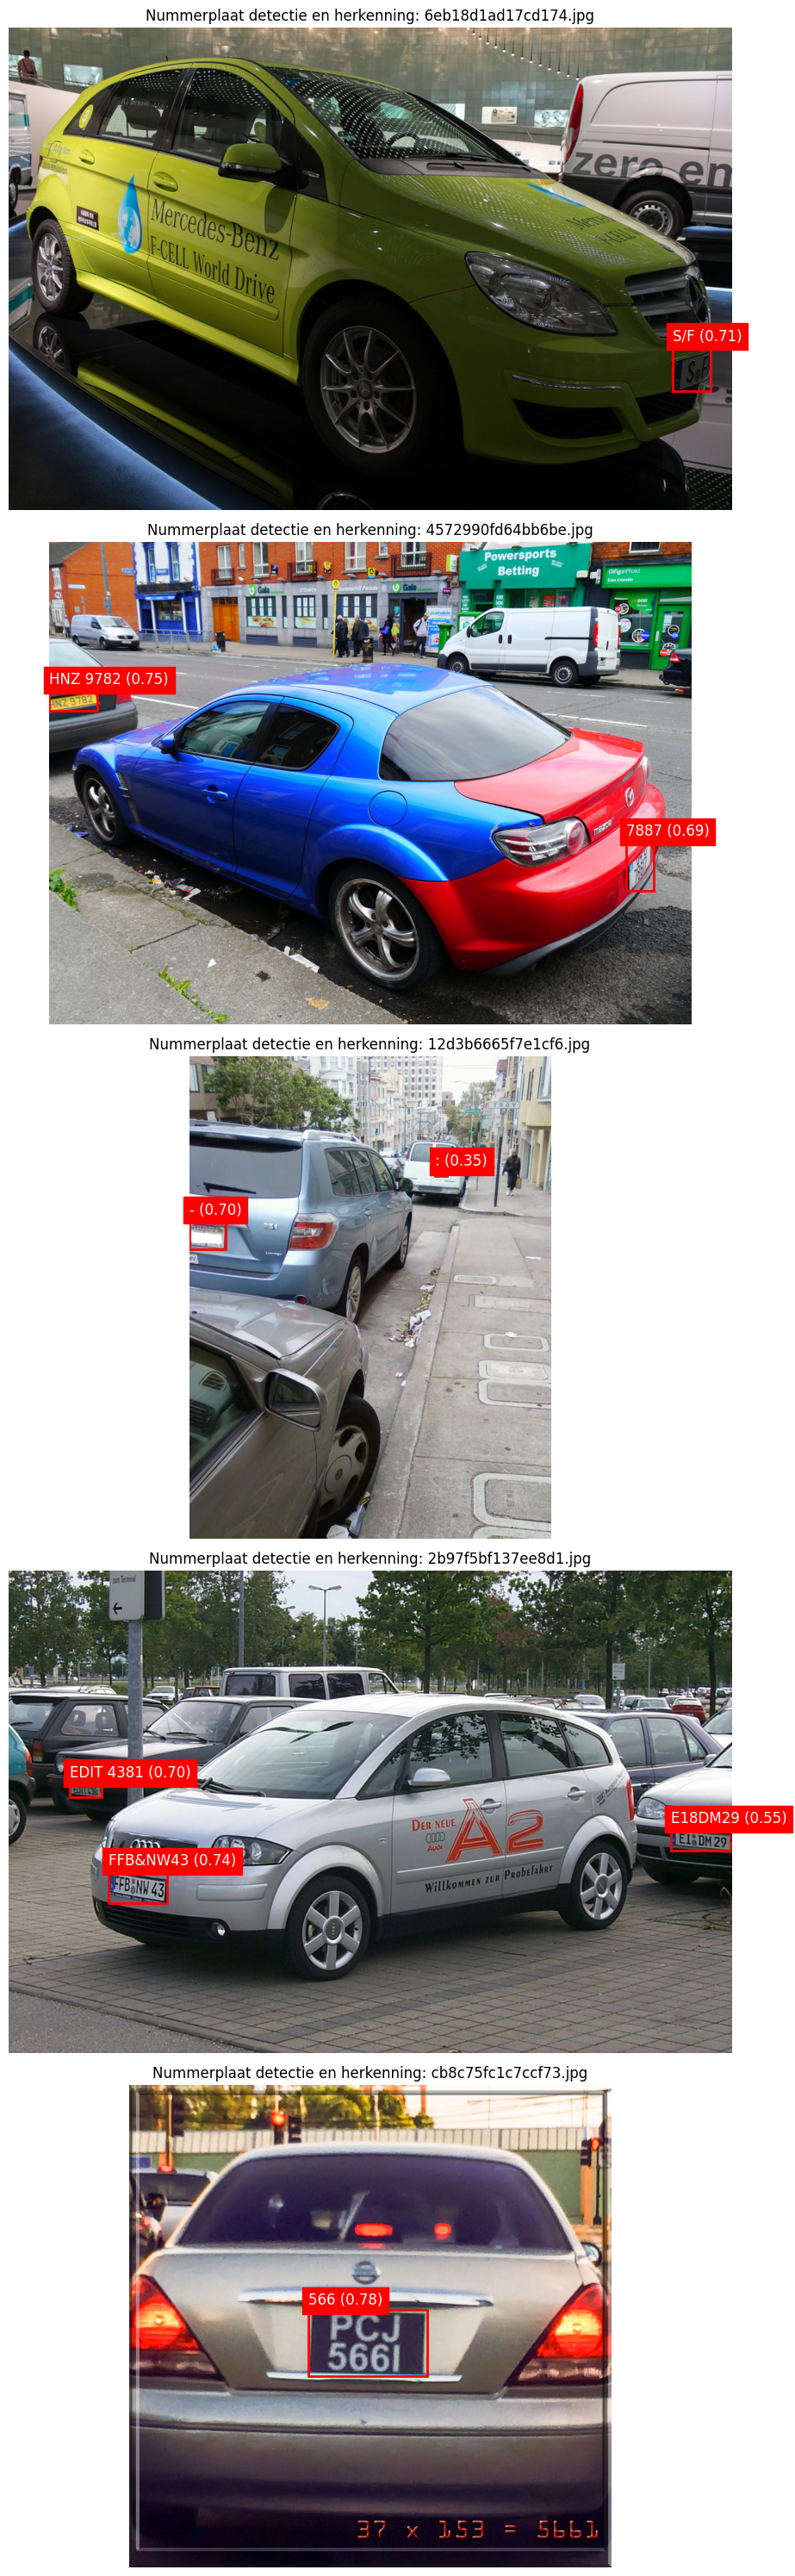


Afbeelding: 6eb18d1ad17cd174.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: S/F (Betrouwbaarheid: 0.71)

Afbeelding: 4572990fd64bb6be.jpg
Gevonden nummerplaten: 2
  Nummerplaat 1: HNZ 9782 (Betrouwbaarheid: 0.75)
  Nummerplaat 2: 7887 (Betrouwbaarheid: 0.69)

Afbeelding: 12d3b6665f7e1cf6.jpg
Gevonden nummerplaten: 2
  Nummerplaat 1: - (Betrouwbaarheid: 0.70)
  Nummerplaat 2: : (Betrouwbaarheid: 0.35)

Afbeelding: 2b97f5bf137ee8d1.jpg
Gevonden nummerplaten: 3
  Nummerplaat 1: FFB&NW43 (Betrouwbaarheid: 0.74)
  Nummerplaat 2: EDIT 4381 (Betrouwbaarheid: 0.70)
  Nummerplaat 3: E18DM29 (Betrouwbaarheid: 0.55)

Afbeelding: cb8c75fc1c7ccf73.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: 566 (Betrouwbaarheid: 0.78)


In [ ]:
test_dir = '../../datasets/license_plate_dataset/images/test'
print(f"Test directory: {test_dir}")

# Get a list of all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
print(f"Found {len(image_files)} image files in test directory")

# Now you can sample from the list
selected_images = random.sample(image_files, min(10, len(image_files)))

# Use already selected images or randomly select 10 images if this hasn't been done yet
if 'selected_images' not in locals():
    selected_images = random.sample(image_files, 10)
    
# Select 5 images for processing
display_count = 5
images_to_process = selected_images[:display_count]

# Create a figure with subplots for all images
fig, axes = plt.subplots(display_count, 1, figsize=(15, 6*display_count))

# If there's only one image, make sure axes is a list
if display_count == 1:
    axes = [axes]

# Process each image and show results
all_results = []

for idx, image_file in enumerate(images_to_process):
    image_path = os.path.join(test_dir, image_file)
    
    # Process the image
    results = process_image(image_path)
    all_results.append({"file": image_file, "results": results})
    
    # Show the image with detected license plates
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(image_rgb)
    
    # Draw bounding boxes and text on the image
    for result in results:
        x1, y1, x2, y2 = result['bbox']
        confidence = result['confidence']
        text = result['text']
        
        # Draw bounding box
        axes[idx].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     fill=False, edgecolor='red', linewidth=2))
        
        # Show text above the bounding box
        axes[idx].text(x1, y1-10, f"{text} ({confidence:.2f})", 
                   color='white', backgroundcolor='red', fontsize=12)
    
    axes[idx].set_title(f"License plate detection and recognition: {image_file}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Show textual results for all images
for img_result in all_results:
    image_file = img_result["file"]
    results = img_result["results"]
    print(f"\nImage: {image_file}")
    print(f"Found license plates: {len(results)}")
    for i, result in enumerate(results):
        print(f"  License plate {i+1}: {result['text']} (Confidence: {result['confidence']:.2f})")